In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import sys
import os
import pickle
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from matplotlib_scalebar.scalebar import ScaleBar
from citymob import import_csv_w_wkt_to_gdf
import re
crs0=3035
cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']
cities_small=['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Toulouse']


Leipzig Germany


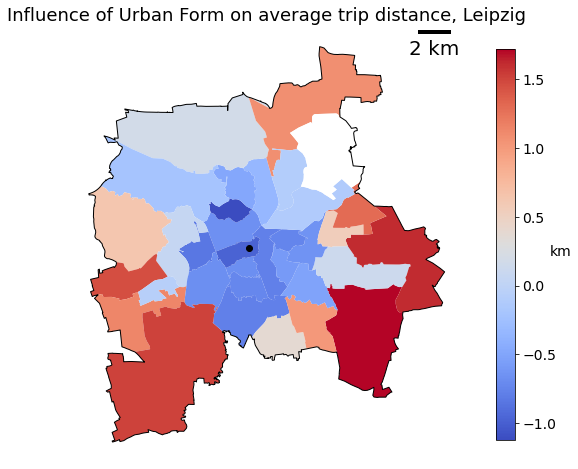

In [6]:
for city in cities_all:

    country=countries[cities_all.index(city)]
    print(city, country)

    if country=='Germany':
        fp='../source/GTFS/postcodes_gpkg/'+city+'_postcodes.gpkg'
        plz_gdf=gpd.read_file(fp)
        plz_gdf['geocode']=plz_gdf['geocode'].astype(str)

    elif (country in ['Spain','France']) & (city not in ['Paris']):
        fp='../outputs/density_geounits/' + city + '_pop_density_mixres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')
    elif city =='Paris':
        fp='../outputs/density_geounits/' + city + '_pop_density_lowres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
        plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
    else: # Wien
        fp='../outputs/density_geounits/' + city + '_pop_density.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')  

    if city in ['Dresden','Leipzig']:
        plz_gdf['geocode']=plz_gdf['geocode'].str.zfill(5)

    df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '.pkl'
    with open(fp, 'rb') as f:
        shap_values=pickle.load(f) 

    shap_values=shap_values*0.001

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl'
    with open(fp, 'rb') as f:
        df_agg=pickle.load(f) 

    if (country == 'Germany'): 
        fp='../outputs/city_boundaries/' + city + '_basic.csv'
    else:
        fp='../outputs/city_boundaries/' + city + '.csv'
    boundary=import_csv_w_wkt_to_gdf(fp,crs=crs0)

    fp='../source/citycenters/centers.csv'
    centers=import_csv_w_wkt_to_gdf(fp,crs=4326)
    centers.to_crs(crs0, inplace=True)
    cp=centers.loc[centers['City']==city,]

    if city == 'Wien':
        feat_ori=shap_values.loc[:,['DistCenter_res','UrbPopDensity_res']]
    elif city in cities_small:
        feat_ori=shap_values.loc[:,['DistCenter_res','UrbPopDensity_res','LU_UrbFab_res','DistSubcenter_res']]
    else:
        feat_ori=shap_values.loc[:,['DistCenter_res','DistSubcenter_res','UrbPopDensity_res','UrbBuildDensity_res','IntersecDensity_res','LU_UrbFab_res']]
    feat_ori['All_UF']=feat_ori.sum(axis=1)

    df_plot_ori=df_agg[['Res_geocode']].drop_duplicates().reset_index(drop=True)
    df_plot_ori=df_plot_ori.merge(feat_ori,left_index=True,right_index=True)

    feat_plot=plz_gdf.loc[:,['geocode','geometry']].copy()
    feat_plot.rename(columns={'geocode':'Res_geocode'},inplace=True)

    feat_plot=feat_plot.merge(df_plot_ori,how='left')

    fig, ax = plt.subplots(figsize=(12,8))

    if city == 'Wien':
        feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),vmax=4,legend_kwds={"label": "horizontal","shrink": 0.9})
    else:
        feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),legend_kwds={"label": "horizontal","shrink": 0.9})
    boundary.plot(edgecolor='k',facecolor='None',ax=ax)
    cp.plot(color='k',ax=ax)
    if city=='Berlin':
        title='a) Influence of Urban Form on average trip distance, '
    elif city == 'Madrid':
        title='b) Influence of Urban Form on average trip distance, '
    elif city == 'Paris':
        title='c) Influence of Urban Form on average trip distance, '
    elif city == 'Wien':
        title='d) Influence of Urban Form on average trip distance, Vienna'
    else:
        title='Influence of Urban Form on average trip distance, '

    if city=='Wien':
        ax.set_title(title,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
    else:
        ax.set_title(title + city,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
        

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=14)
    cb_ax.set_ylabel('km',rotation=0,fontsize=14)
    plt.axis('off') # this removes the figure frame and the lat/lon coords
    plt.savefig('../outputs/ML_Results/result_figures/dist_agg/' + city + '_UF_map_ori.png',facecolor='w',dpi=300,bbox_inches='tight')

Madrid Spain


C:\Users\peter\AppData\Local\Temp\ipykernel_17452\1507276594.py:26: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


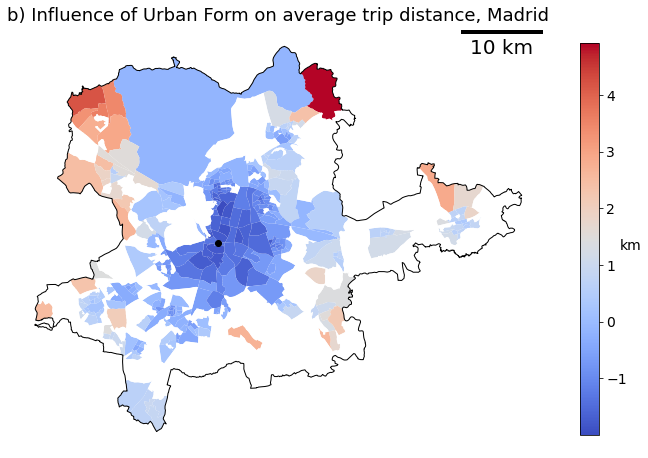

In [7]:
for city in pd.Series(['Madrid']):
    country='Spain'
    # country=countries[cities_all.index(city)]
    
    print(city, country)

    if country=='Germany':
        fp='../source/GTFS/postcodes_gpkg/'+city+'_postcodes.gpkg'
        plz_gdf=gpd.read_file(fp)
        plz_gdf['geocode']=plz_gdf['geocode'].astype(str)

    elif (country in ['Spain','France']) & (city not in ['Paris']):
        fp='../outputs/density_geounits/' + city + '_pop_density_mixres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')
    elif city =='Paris':
        fp='../outputs/density_geounits/' + city + '_pop_density_lowres.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geo_unit')
        plz_gdf.rename(columns={'geo_unit':'geocode'},inplace=True)
    else: # Wien
        fp='../outputs/density_geounits/' + city + '_pop_density.csv'
        plz_gdf=import_csv_w_wkt_to_gdf(fp,crs=crs0,gc='geocode')  

    if city in ['Dresden','Leipzig']:
        plz_gdf['geocode']=plz_gdf['geocode'].str.zfill(5)

    df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '.pkl'
    with open(fp, 'rb') as f:
        shap_values=pickle.load(f) 

    shap_values=shap_values*0.001

    fp='../outputs/ML_Results/shap/dist_agg/' + city + '_df.pkl'
    with open(fp, 'rb') as f:
        df_agg=pickle.load(f) 

    if (country == 'Germany'): 
        fp='../outputs/city_boundaries/' + city + '_basic.csv'
    else:
        fp='../outputs/city_boundaries/' + city + '.csv'
    boundary=import_csv_w_wkt_to_gdf(fp,crs=crs0)

    fp='../source/citycenters/centers.csv'
    centers=import_csv_w_wkt_to_gdf(fp,crs=4326)
    centers.to_crs(crs0, inplace=True)
    cp=centers.loc[centers['City']==city,]

    if city == 'Wien':
        feat_ori=shap_values.loc[:,['DistCenter_res','UrbPopDensity_res']]
    elif city in cities_small:
        feat_ori=shap_values.loc[:,['DistCenter_res','UrbPopDensity_res','LU_UrbFab_res','DistSubcenter_res']]
    else:
        feat_ori=shap_values.loc[:,['DistCenter_res','DistSubcenter_res','UrbPopDensity_res','UrbBuildDensity_res','IntersecDensity_res','LU_UrbFab_res']]
    feat_ori['All_UF']=feat_ori.sum(axis=1)

    df_plot_ori=df_agg[['Res_geocode']].drop_duplicates().reset_index(drop=True)
    df_plot_ori=df_plot_ori.merge(feat_ori,left_index=True,right_index=True)

    feat_plot=plz_gdf.loc[:,['geocode','geometry']].copy()
    feat_plot.rename(columns={'geocode':'Res_geocode'},inplace=True)

    feat_plot=feat_plot.merge(df_plot_ori,how='left')

    fig, ax = plt.subplots(figsize=(12,8))

    if city == 'Wien':
        feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),vmax=4,legend_kwds={"label": "horizontal","shrink": 0.9})
    else:
        feat_plot.plot(column='All_UF',ax=ax,legend=True,cmap='coolwarm',missing_kwds= dict(color = "white"),legend_kwds={"label": "horizontal","shrink": 0.9})
    boundary.plot(edgecolor='k',facecolor='None',ax=ax)
    cp.plot(color='k',ax=ax)
    if city=='Berlin':
        title='a) Influence of Urban Form on average trip distance, '
    elif city == 'Madrid':
        title='b) Influence of Urban Form on average trip distance, '
    elif city == 'Paris':
        title='c) Influence of Urban Form on average trip distance, '
    elif city == 'Wien':
        title='d) Influence of Urban Form on average trip distance, Vienna'
    else:
        title='Influence of Urban Form on average trip distance, '

    if city=='Wien':
        ax.set_title(title,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
    else:
        ax.set_title(title + city,size=18)
        ax.add_artist(ScaleBar(1,font_properties={'size':20}))
        

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=14)
    cb_ax.set_ylabel('km',rotation=0,fontsize=14)
    plt.axis('off') # this removes the figure frame and the lat/lon coords
    #plt.savefig('../outputs/ML_Results/result_figures/dist_agg/' + city + '_UF_map_ori.png',facecolor='w',dpi=300,bbox_inches='tight')

In [19]:
city='Leipzig'

In [20]:
df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv',dtype={'Ori_geocode': str, 'Des_geocode': str,'Res_geocode': str })
df['Commute_Trip']=0
df.loc[df['Trip_Purpose_Agg']=='Home↔Work','Commute_Trip']=1
df_UF=df.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res',
                #'PopDensity_res','BuildDensity_res',
                'UrbPopDensity_res', 'UrbBuildDensity_res',
                'IntersecDensity_res', 'street_length_res', 'LU_UrbFab_res',#'bike_lane_share_res',
                'LU_Comm_res', 'Commute_Trip','Age','Trip_Distance']]

count=df_UF.groupby('Res_geocode')['Trip_Distance'].count().reset_index()
count.rename(columns={'Trip_Distance':'count'},inplace=True)
df_UF=df_UF.groupby('Res_geocode').mean().drop_duplicates() #
df_UF.reset_index(inplace=True)

df_UF=df_UF.merge(count)

In [21]:
df_UF=df_UF.loc[df_UF['count']>4,]

In [22]:
df_agg=df_UF.copy()
N=len(df_UF)

df_agg.sort_values(by='Res_geocode',inplace=True)
# df_agg.dropna(subset=['Trip_Distance'],inplace=True)
# df_agg=df_agg.loc[df_agg['UrbBuildDensity_res']<1e8,:]
# if city=='Wien':
#         df_agg=df_agg.loc[:,['Res_geocode', 'DistCenter_res','UrbPopDensity_res','Commute_Trip','Trip_Distance','count']]
# elif city in cities_small:
#         df_agg=df_agg.loc[:,['Res_geocode', 'DistCenter_res','UrbPopDensity_res','Commute_Trip','LU_UrbFab_res','DistSubcenter_res','Trip_Distance','count']]
# else:
#         df_agg=df_agg.loc[:,['Res_geocode', 'DistSubcenter_res', 'DistCenter_res','UrbPopDensity_res',
#                             'UrbBuildDensity_res','IntersecDensity_res',  'LU_UrbFab_res','Commute_Trip','Age','Trip_Distance','count']]

# target='Trip_Distance'

# X=df_agg.drop(columns=['Res_geocode','count',target])
# y=df_agg['Trip_Distance']

In [16]:
df_agg.dropna(subset=['Trip_Distance'],inplace=True)

In [23]:
df_UF.sort_values(by='UrbBuildDensity_res')

,Res_geocode,DistSubcenter_res,DistCenter_res,UrbPopDensity_res,UrbBuildDensity_res,IntersecDensity_res,street_length_res,LU_UrbFab_res,LU_Comm_res,Commute_Trip,Age,Trip_Distance,count
20,04288,5.929176,8.091901,1768.594974,9.457607e+05,15.507492,140.383930,0.161410,0.052603,0.220974,45.329588,6246.007491,267
24,04316,3.509486,5.673065,2011.010174,1.198721e+06,21.016732,125.022407,0.261125,0.070890,0.148649,40.229730,5116.310811,148
21,04289,4.138098,6.125373,1892.021161,1.284082e+06,35.708040,106.237191,0.346242,0.106851,0.239726,50.589041,5510.876712,146
18,04277,1.841976,3.810284,3052.824186,1.426404e+06,40.605143,117.973197,0.216220,0.089763,0.182099,34.429012,5183.407407,324
16,04249,7.102279,9.362044,1292.536593,1.448464e+06,19.996503,130.912701,0.092196,0.068329,0.145695,40.069536,5855.139073,302
27,04319,5.597107,7.514024,2030.566615,1.460193e+06,39.993005,86.859866,0.143047,0.085928,0.252577,43.226804,6407.335052,194
19,04279,3.682953,5.580095,3153.169877,1.606207e+06,26.117881,123.204018,0.210124,0.123688,0.150000,51.605882,4785.305882,340
13,04207,4.474477,7.532387,4209.148636,1.636236e+06,32.239259,136.972519,0.298202,0.069851,0.182741,57.272420,6430.607445,591
22,04299,1.828388,3.977456,4549.653613,1.669477e+06,37.340408,112.740602,0.337482,0.071332,0.153941,42.337438,4093.844828,1624
8,04159,4.334499,4.912615,3082.654226,1.828188e+06,30.810938,118.535117,0.174227,0.097596,0.229508,42.300546,7265.945355,183


In [17]:
df_agg=df_agg.loc[df_agg['UrbBuildDensity_res']<1e8,:]